# Introduction to probabilistic programming
## *Simple example: noisy linear regression*

In [2]:
using Gen
using PyPlot
const plt = PyPlot

┌ Info: Precompiling Gen [ea4f424c-a589-11e8-07c0-fd5c91b9da4a]
└ @ Base loading.jl:1273


PyPlot

In [3]:
"""
    line_model(xs)

Generate a probabilistic model for a linear fit to some data `xs` given by
y(x) = mx + b + ϵ where m is the slope, b in the intercept, and ϵ is some noise.
"""
@gen function line_model(xs)
    m ~ normal(0, 1)
    b ~ normal(0, 2)
    ϵ ~ gamma(1, 1)
    
    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(m*x + b, ϵ)
    end
    
    return nothing
end

line_model

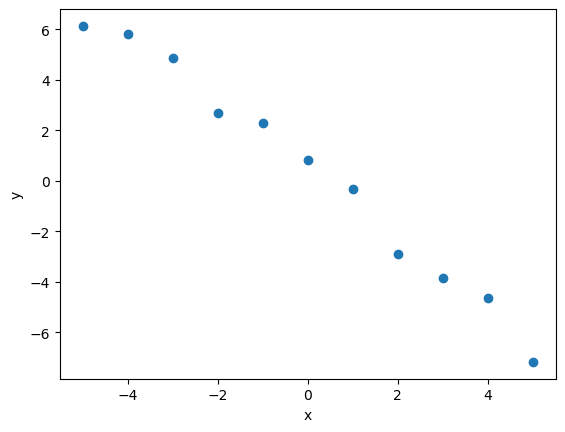

PyObject Text(24.000000000000007, 0.5, 'y')

In [6]:
# Parameters used to generate line data (and which we will try to infer).
m′ = -1.4
b′ = 0.5
ϵ′ = 0.4

xs = -5.0:1.0:5.0 |> collect
ys = @.m′*xs + b′ + ϵ′*randn()

plt.scatter(xs, ys)
plt.xlabel("x")
plt.ylabel("y")

In [8]:
function infer_line_model_parameters(xs, ys; n_samples)
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    line_model_params = Gen.select(:m, :b, :ϵ)
    
    ms = zeros(n_samples)
    bs = zeros(n_samples)
    ϵs = zeros(n_samples)
    
    n_mh_steps = 0
    n_accepted_steps = 0
    
    trace, _ = Gen.generate(line_model, (xs,), observations)
    while n_accepted_steps < n_samples
        trace, accepted = metropolis_hastings(trace, line_model_params, observations=observations)
        if accepted
            n_accepted_steps = n_accepted_steps + 1
            
            choices = Gen.get_choices(trace)
            ms[n_accepted_steps] = choices[:m]
            bs[n_accepted_steps] = choices[:b]
            ϵs[n_accepted_steps] = choices[:ϵ]
        end
        n_mh_steps = n_mh_steps + 1
    end
    
    println("# of accepted steps: $n_accepted_steps")
    println("# of MH steps: $n_mh_steps")
    println("Acceptence ratio: $(n_accepted_steps/n_mh_steps)")
    
    return ms, bs, ϵs
end

infer_line_model_parameters (generic function with 1 method)

In [17]:
function plot_inference!(axes, xs, ys, ms, bs, ϵs, truth, bins)
    m′, b′, ϵ′ = truth
    
    # Trace plots of MCMC draws
    axes[1, 1].plot(ms)
    axes[1, 1].set_xlabel("sample")
    axes[1, 1].set_ylabel("m")

    axes[1, 2].plot(bs)
    axes[1, 2].set_xlabel("sample")
    axes[1, 2].set_ylabel("b")

    axes[1, 3].plot(ϵs)
    axes[1, 3].set_xlabel("sample")
    axes[1, 3].set_ylabel("ϵ")

    # Parameter posterior pdfs
    axes[2, 1].hist(ms, label="posterior", bins=bins, density=true)
    axes[2, 1].set_xlabel("m")
    axes[2, 1].set_ylabel("p(m)")
    axes[2, 1].set_xlim([-2, 2])

    axes[2, 2].hist(bs, label="posterior", bins=bins, density=true)
    axes[2, 2].set_xlabel("b")
    axes[2, 2].set_ylabel("p(b)")
    axes[2, 2].set_xlim([-3, 3])

    axes[2, 3].hist(ϵs, label="posterior", bins=bins, density=true)
    axes[2, 3].set_xlabel("ϵ")
    axes[2, 3].set_ylabel("p(ϵ)")
    axes[2, 3].set_xlim([0, 3])
    
    # Overlay some priors
    normal_pdf(x; μ, σ) = exp(Gen.logpdf(Gen.normal, x, μ, σ))
    gamma_pdf(x; k, θ) = exp(Gen.logpdf(Gen.gamma, x, k, θ))
    
    m_xs = range(-2, 2, length=1000)
    m_ys = @. normal_pdf(m_xs, μ=0.0, σ=1.0)
    axes[2, 1].plot(m_xs, m_ys, label="prior")
    
    b_xs = range(-3, 3, length=1000)
    b_ys = @. normal_pdf(b_xs, μ=0.0, σ=2.0)
    axes[2, 2].plot(b_xs, b_ys, label="prior")
    
    ϵ_xs = range(0, 3, length=1000)
    ϵ_ys = @. gamma_pdf(ϵ_xs, k=1.0, θ=1.0)
    axes[2, 3].plot(ϵ_xs, ϵ_ys, label="prior")
    
    # Show truth values
    axes[2, 1].axvline(m′, label="truth", color="tab:red", linestyle="--")
    axes[2, 2].axvline(b′, label="truth", color="tab:red", linestyle="--")
    axes[2, 3].axvline(ϵ′, label="truth", color="tab:red", linestyle="--")
    
    # Should probably add a legend
    axes[2, 3].legend(loc="best", frameon=false)
    
    return nothing
end

plot_inference! (generic function with 1 method)

In [18]:
function infer_and_plot(xs, ys; n_samples, truth, bins=10)
    ms, bs, ϵs = infer_line_model_parameters(xs, ys, n_samples=n_samples)
    
    fig, axes = PyPlot.subplots(nrows=2, ncols=3, figsize=(16, 9))
    fig.suptitle("Noisy linear regression (Metropolis-Hastings, $n_samples samples)")

    plot_inference!(axes, xs, ys, ms, bs, ϵs, truth, bins)
    
    return ms, bs, ϵs
end

infer_and_plot (generic function with 1 method)

# of accepted steps: 100
# of MH steps: 49655
Acceptence ratio: 0.002013895881582922


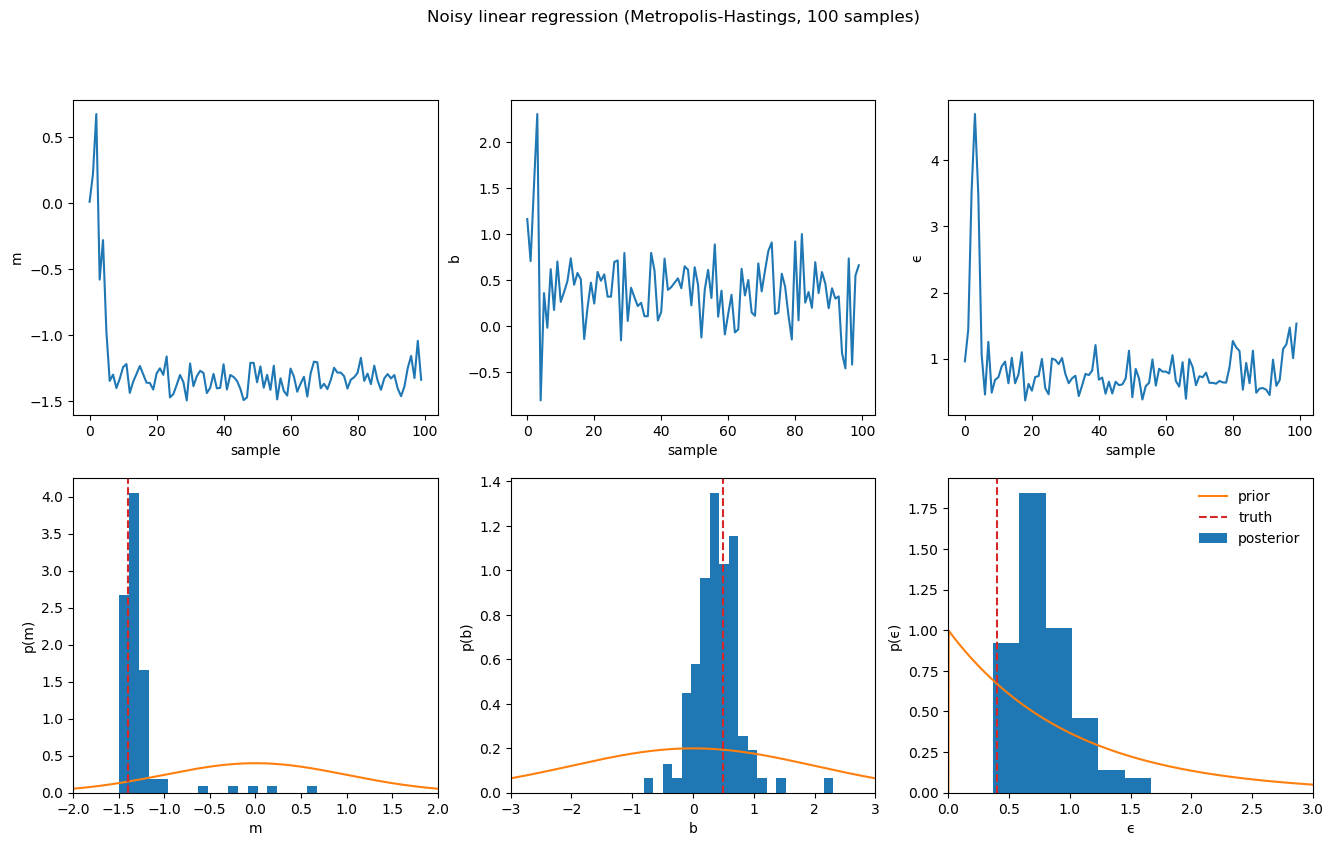

  2.940520 seconds (6.81 M allocations: 357.028 MiB, 2.27% gc time)


In [31]:
@time infer_and_plot(xs, ys, n_samples=100, truth=(m′, b′, ϵ′), bins=20);

# of accepted steps: 1000
# of MH steps: 497229
Acceptence ratio: 0.002011145769856545


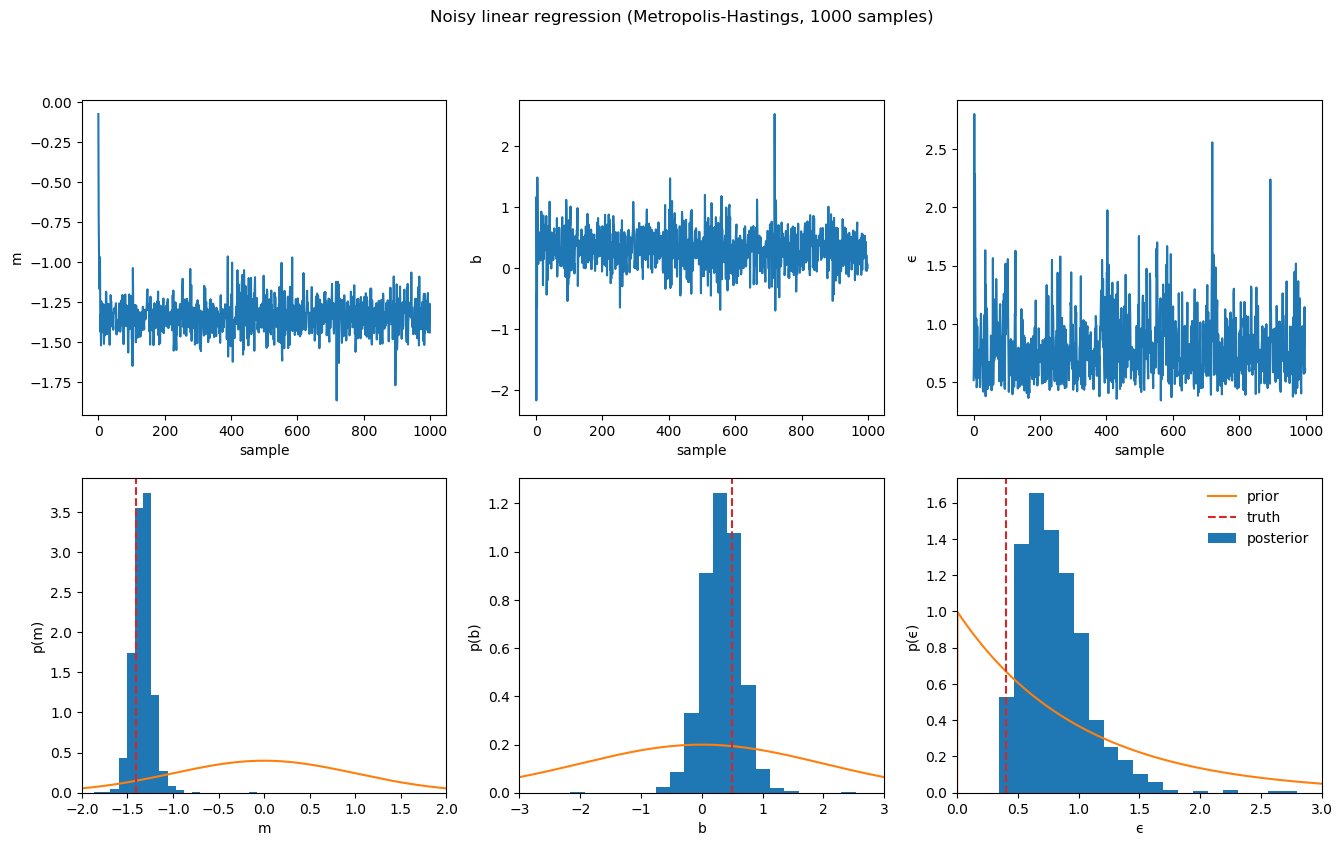

 25.709942 seconds (68.13 M allocations: 3.490 GiB, 3.12% gc time)


In [24]:
@time infer_and_plot(xs, ys, n_samples=1000, truth=(m′, b′, ϵ′), bins=20);

# of accepted steps: 10000
# of MH steps: 5345392
Acceptence ratio: 0.0018707701886035673


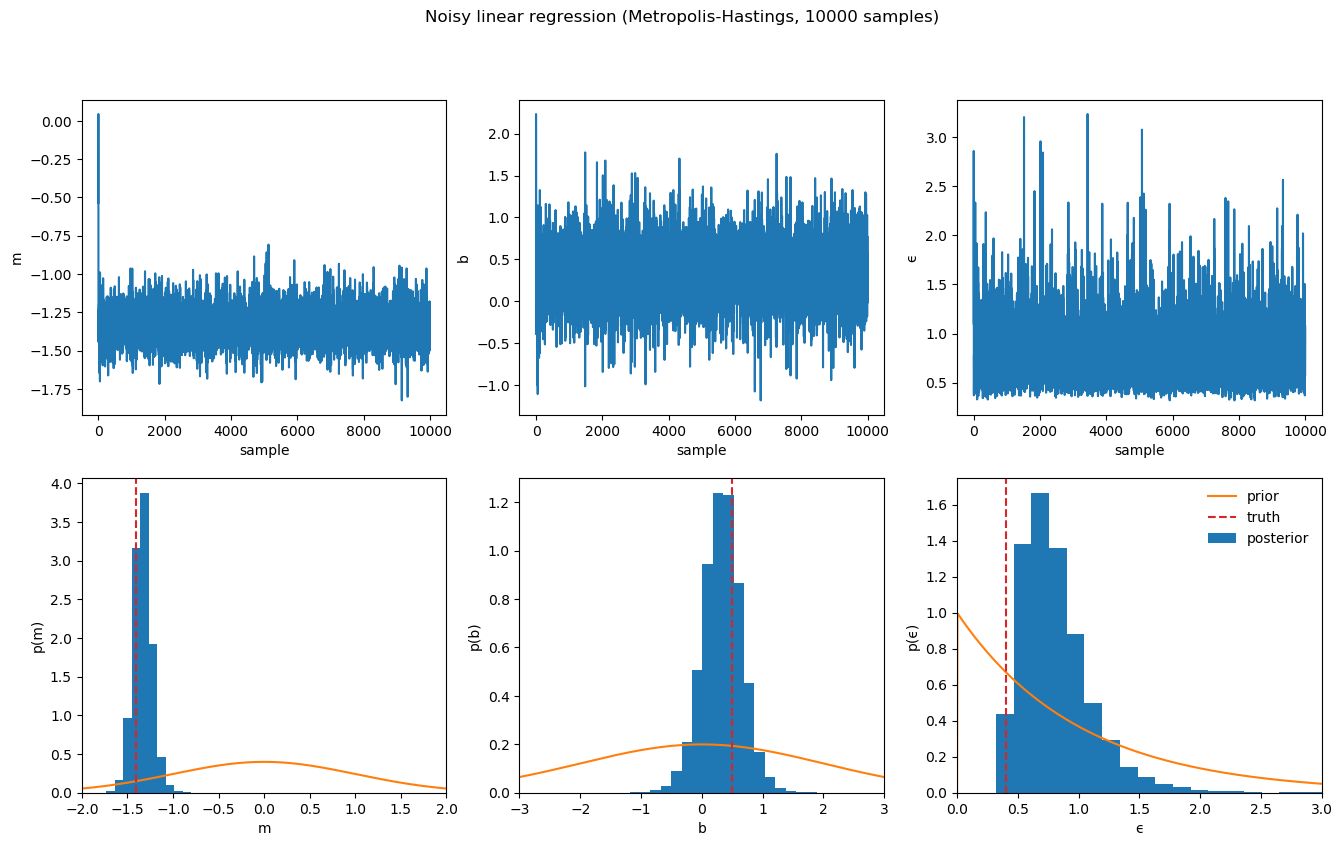

269.305899 seconds (732.39 M allocations: 37.518 GiB, 3.04% gc time)


In [25]:
@time infer_and_plot(xs, ys, n_samples=10000, truth=(m′, b′, ϵ′), bins=20);

In [26]:
function infer_line_model_parameters_hmc(xs, ys; n_samples, max_iters)
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    line_model_params = Gen.select(:m, :b, :ϵ)
    
    ms = zeros(n_samples)
    bs = zeros(n_samples)
    ϵs = zeros(n_samples)
    
    n_hmc_steps = 0
    n_accepted_steps = 0
    
    trace, _ = Gen.generate(line_model, (xs,), observations)
    while n_accepted_steps < n_samples
        trace, accepted = Gen.hmc(trace, line_model_params, eps=0.01, observations=observations)
        if accepted
            n_accepted_steps = n_accepted_steps + 1
            choices = Gen.get_choices(trace)
            ms[n_accepted_steps] = choices[:m]
            bs[n_accepted_steps] = choices[:b]
            ϵs[n_accepted_steps] = choices[:ϵ]
        end
        n_hmc_steps = n_hmc_steps + 1
        n_hmc_steps > max_iters && break
    end
    
    println("# of accepted steps: $n_accepted_steps")
    println("# of HMC steps: $n_hmc_steps")
    println("Acceptence ratio: $(n_accepted_steps/n_hmc_steps)")
    
    return ms, bs, ϵs
end

function infer_and_plot_hmc(xs, ys; n_samples, max_iters, truth, bins=10)
    ms, bs, ϵs = infer_line_model_parameters_hmc(xs, ys, n_samples=n_samples, max_iters=max_iters)
    
    fig, axes = PyPlot.subplots(nrows=2, ncols=3, figsize=(16, 9))
    fig.suptitle("Hamiltonian Monte Carlo ($(length(ms)) samples)")

    plot_inference!(axes, xs, ys, ms, bs, ϵs, truth, bins)
    
    return ms, bs, ϵs
end

infer_and_plot_hmc (generic function with 1 method)

# of accepted steps: 100
# of HMC steps: 100
Acceptence ratio: 1.0


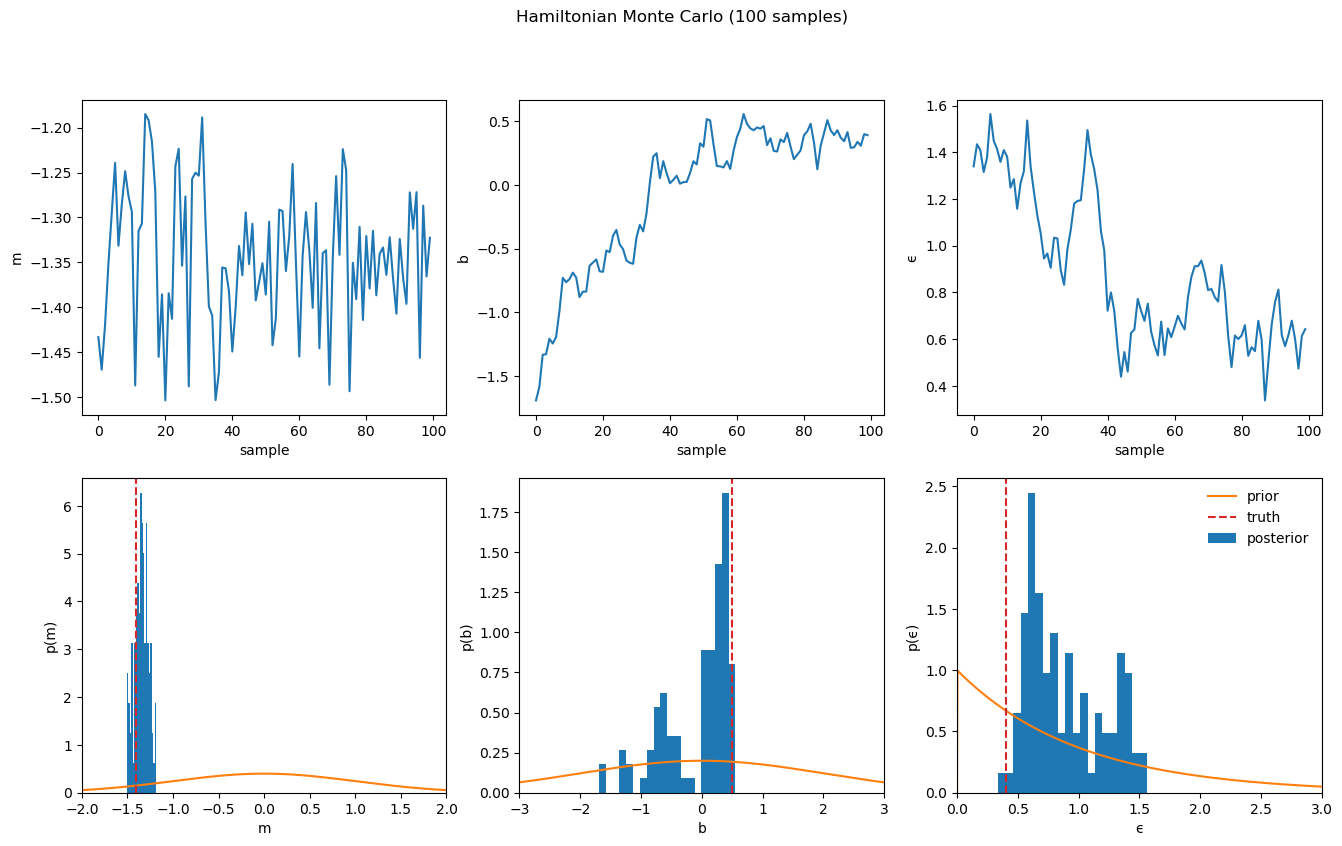

  0.793168 seconds (1.25 M allocations: 50.650 MiB, 0.94% gc time)


In [32]:
@time infer_and_plot_hmc(xs, ys, n_samples=100, max_iters=200, truth=(m′, b′,ϵ′), bins=20);

# of accepted steps: 1000
# of HMC steps: 1003
Acceptence ratio: 0.9970089730807578


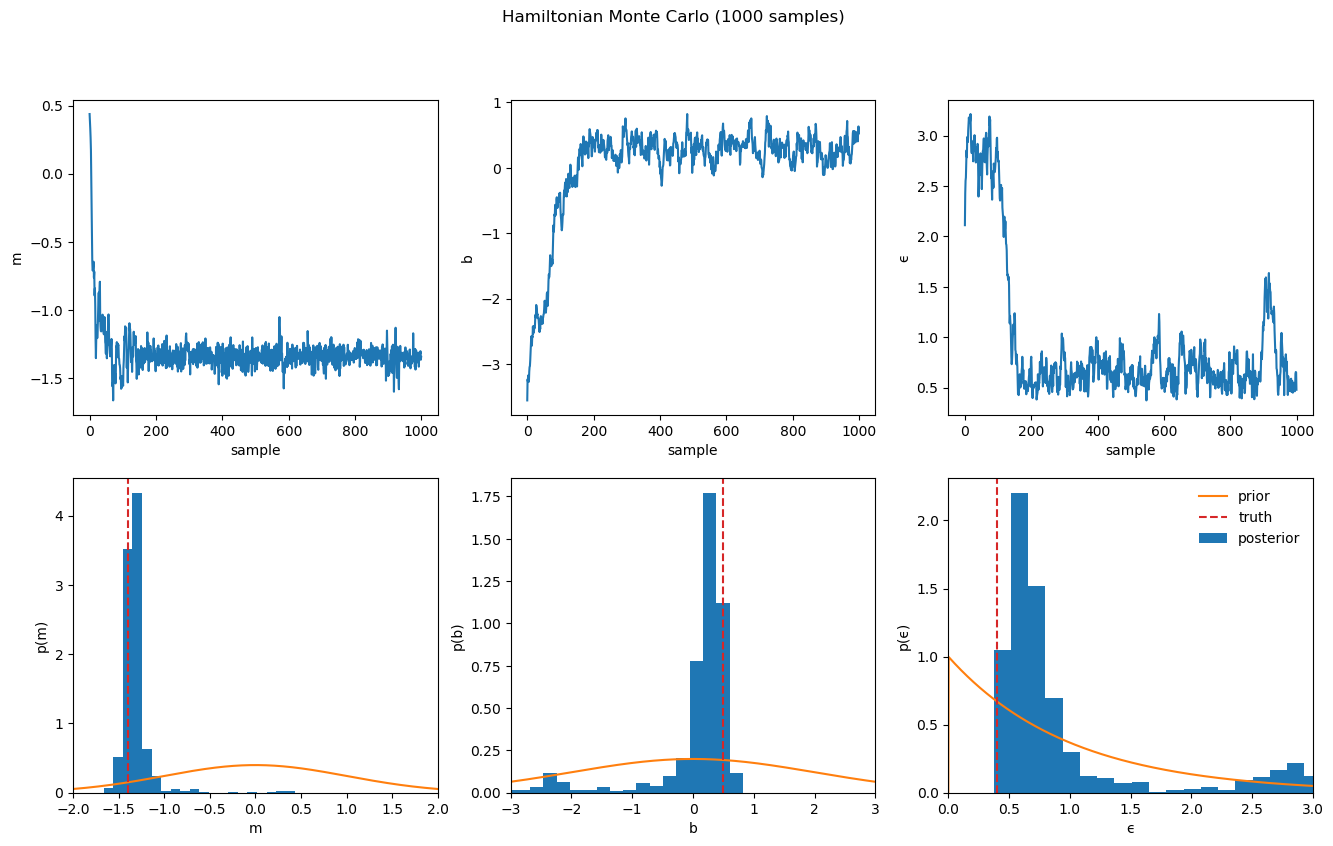

  4.373711 seconds (12.47 M allocations: 506.644 MiB, 2.79% gc time)


In [34]:
@time infer_and_plot_hmc(xs, ys, n_samples=1000, max_iters=2000, truth=(m′, b′,ϵ′), bins=20);

# of accepted steps: 10000
# of HMC steps: 10020
Acceptence ratio: 0.998003992015968


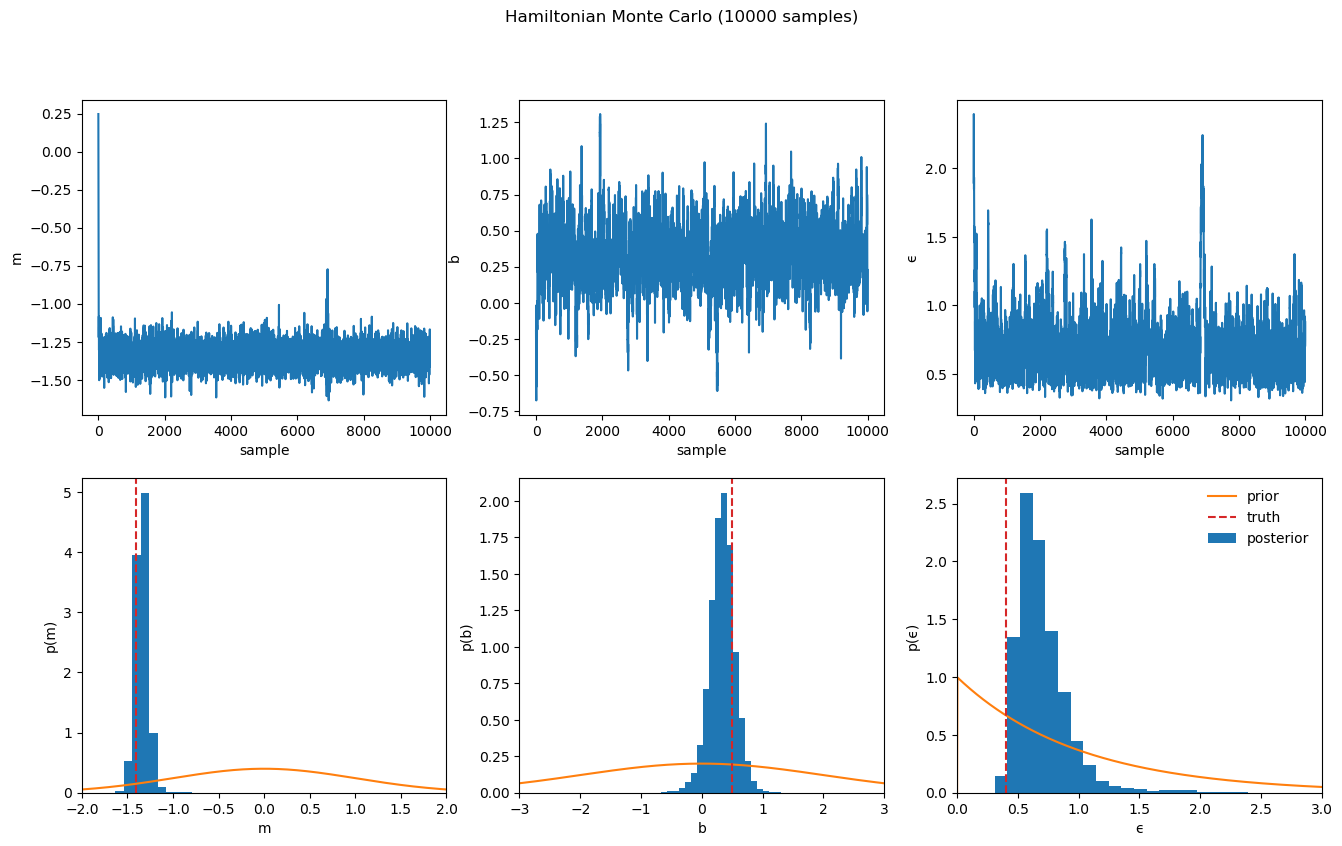

 37.004694 seconds (124.57 M allocations: 4.942 GiB, 2.44% gc time)


In [30]:
@time infer_and_plot_hmc(xs, ys, n_samples=10000, max_iters=20000, truth=(m′, b′,ϵ′), bins=20);